In [1]:
# import sys
# print(sys.executable)
# print(sys.version)

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import wrf
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import xarray as xr
from numba import njit

wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)
plots_dir = nb_dir[0]+'/plots_04e'

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

In [2]:
data_dir_df

,2018-08-05,2018-09-01
mynn,l1_0805m,o1_0901m_30s
mynn_ck0.1,l7_0805m-ck,NaN
edmf,l2_0805e,o2_0901e_30s
mynn_all4d-1arcs-topo,l5_0805m,NaN
mynn_d12-9s_d34-1s_lu,n1_d12-9s_d34-1s,NaN
mynn_d123-9s_d4-1s_lu,n2_d123-9s_d4-1s,NaN
mynn_all4d-9arcs_lu,n3_9s,NaN
wrf_start,8/4/18 12:00,8/31/18 12:00


In [3]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [4]:
def plot_1lev_diff_contour(run1, run2, wrf_var):

    date_col = data_dir_df[eval_date]

    for ind, hr in enumerate(np.arange(16, 24, 1)): 

        file1 = wrf_runs_dir+date_col[run1]+'/wrfout_d04_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single1 = Dataset(file1, 'r')

        var1 = wrf.getvar(wrf_single1, wrf_var, timeidx=wrf.ALL_TIMES)

        if ind == 0: 
            var_all1 = var1
        else: 
            var_all1 = xr.concat([var_all1, var1], dim='Time')

        file2 = wrf_runs_dir+date_col[run2]+'/wrfout_d04_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single2 = Dataset(file2, 'r')

        var2 = wrf.getvar(wrf_single2, wrf_var, timeidx=wrf.ALL_TIMES)

        if ind == 0: 
            var_all2 = var2
        else: 
            var_all2 = xr.concat([var_all2, var2], dim='Time')

    var_all = var_all1 - var_all2

    var_all = var_all.assign_coords(var_all1.coords)
    var_all = var_all.assign_attrs(var_all1.attrs)

    lats, lons = wrf.latlon_coords(var_all)

    fig, (axs1, axs2) = plt.subplots(2, 4, figsize=(15, 10))

    time_list = pd.date_range(start=eval_date+'-16', end=eval_date+'-23', periods=8)

    var_subset = var_all.sel(Time=slice(time_list.min(), time_list.max()))
    v_min = var_subset.min()
    v_max = var_subset.max()

    orig_cmap = matplotlib.cm.coolwarm
    shrunk_cmap = shiftedColorMap(orig_cmap, midpoint=1-(v_max/(v_max+abs(v_min))), name='shrunk')

    for ind, time in enumerate(time_list):

        var_1time = var_subset.sel(Time=time)

        if ind <= 3: 
            axs = axs1
        else: 
            axs = axs2
            ind -= 4

        bm = wrf.get_basemap(var_1time, ax=axs[ind])

        bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
        bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

        x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

        p = bm.contourf(x, y, wrf.to_np(var_1time), cmap=shrunk_cmap)

        axs[ind].set_title(str(time.hour)+' UTC')

        c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
        bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=axs[ind])

        c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.613))
        axs[ind].annotate('C1', xy=(c1x, c1y), size=15, color='white')

    cax = plt.axes([0.25, 0.01, 0.5, 0.04])
    sm = plt.cm.ScalarMappable(cmap=shrunk_cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal', label='['+var_all.units+']')

    plt.suptitle(run1+' - '+run2+' DIFF\n'+eval_date+'\n'+var_all.description)

    #     plt.savefig(plots_dir+'/'+eval_date+'_'+wrf_var+'_'+run+'.pdf')

    plt.show()

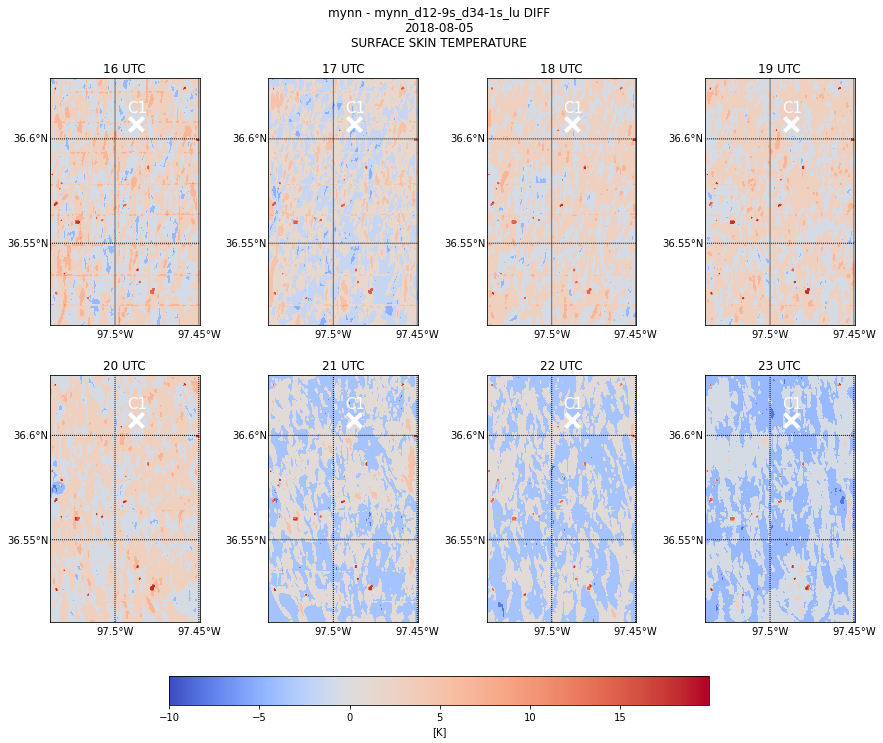

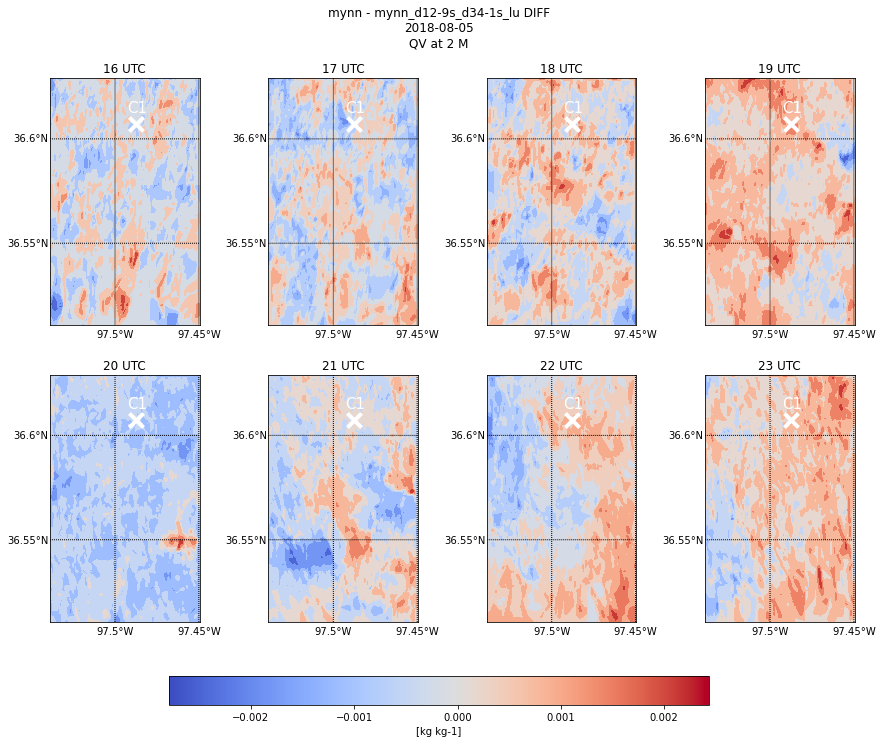

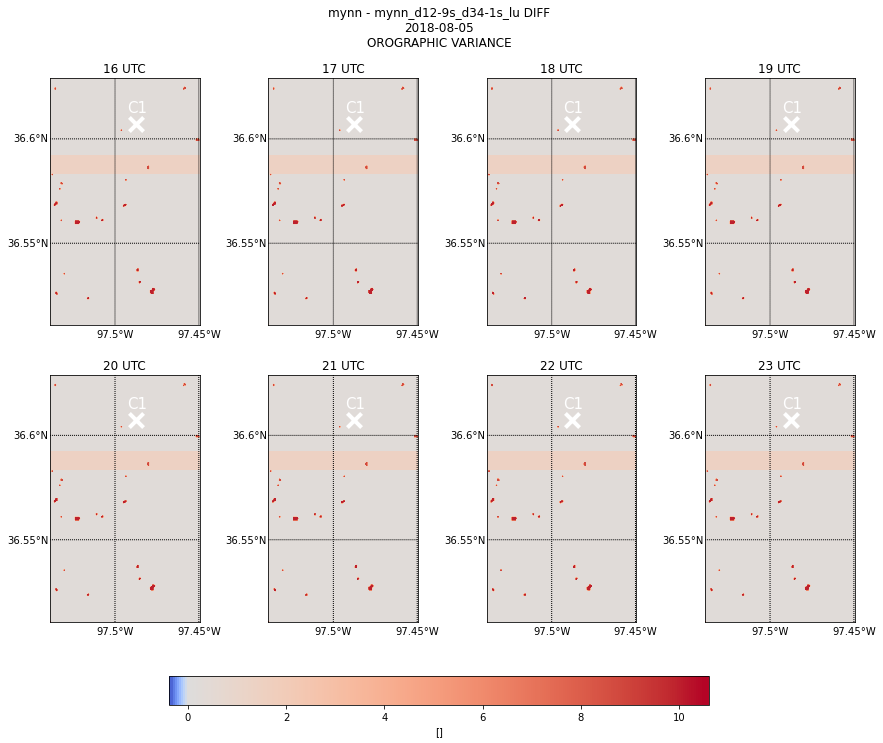

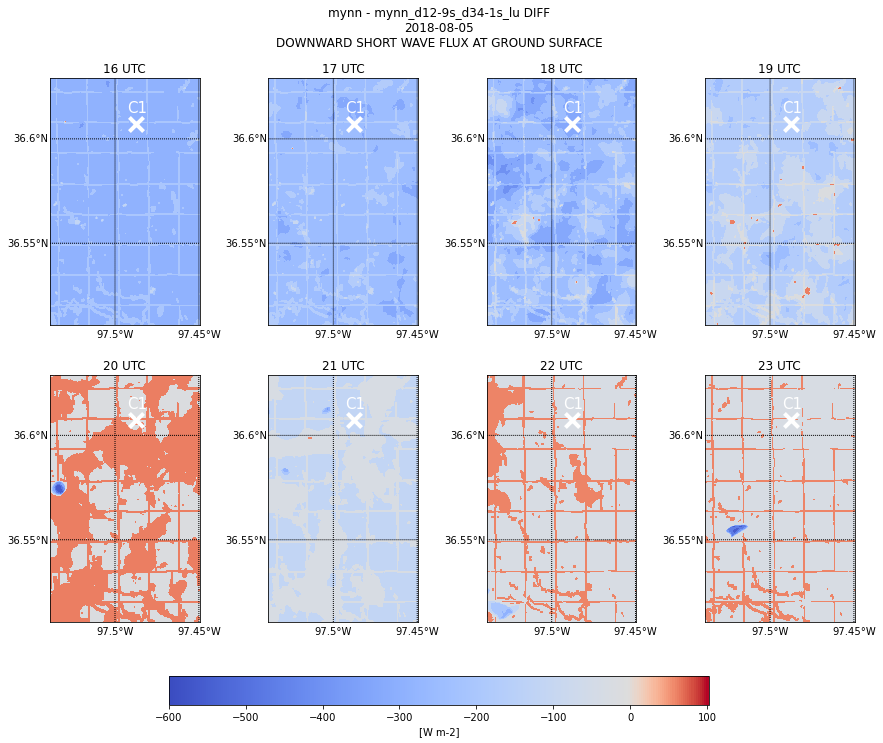

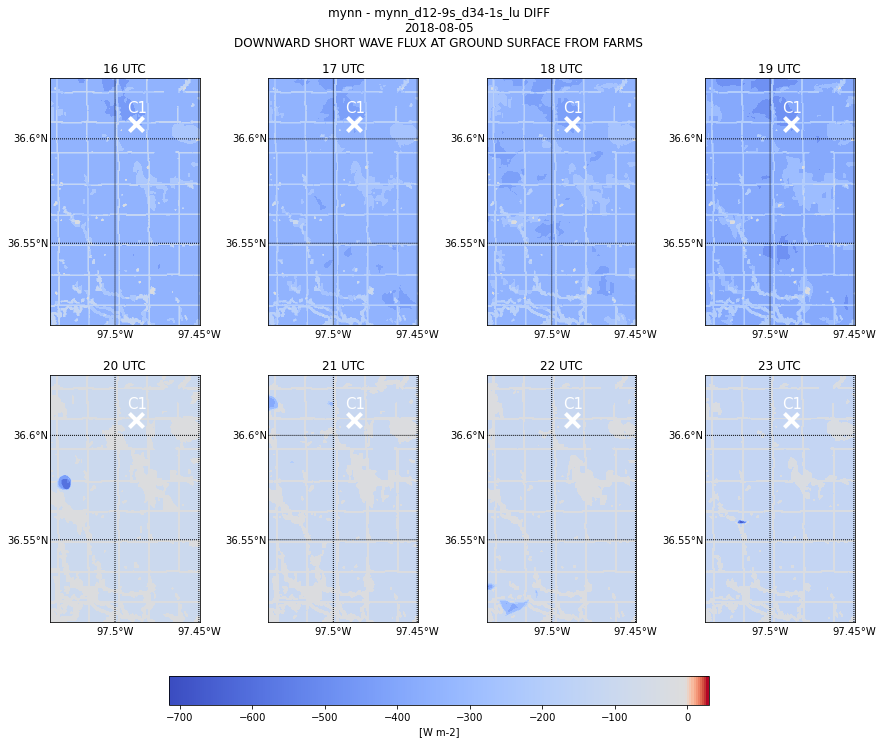

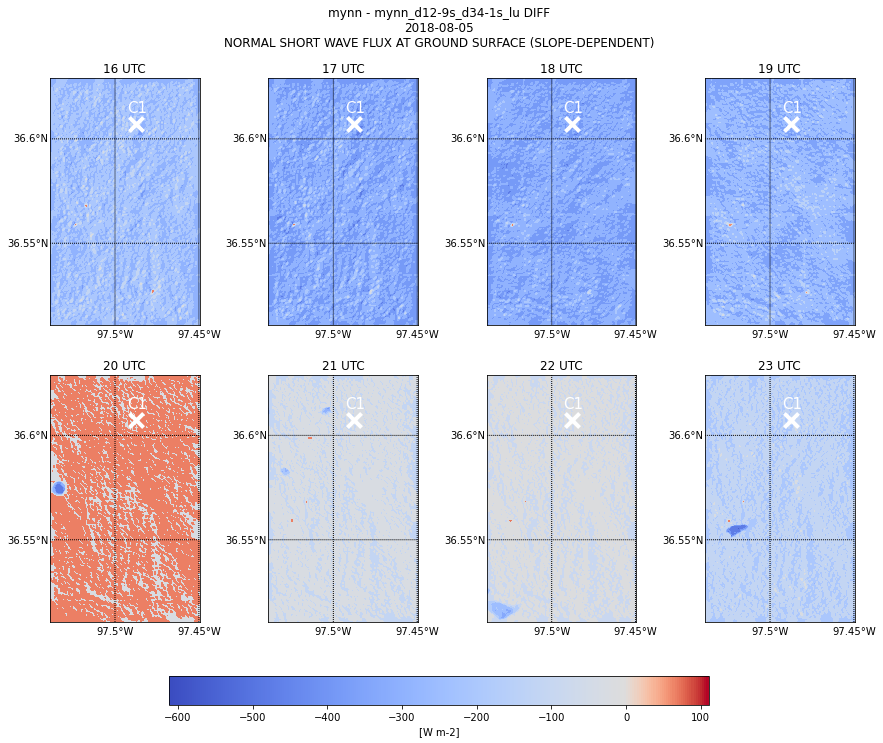

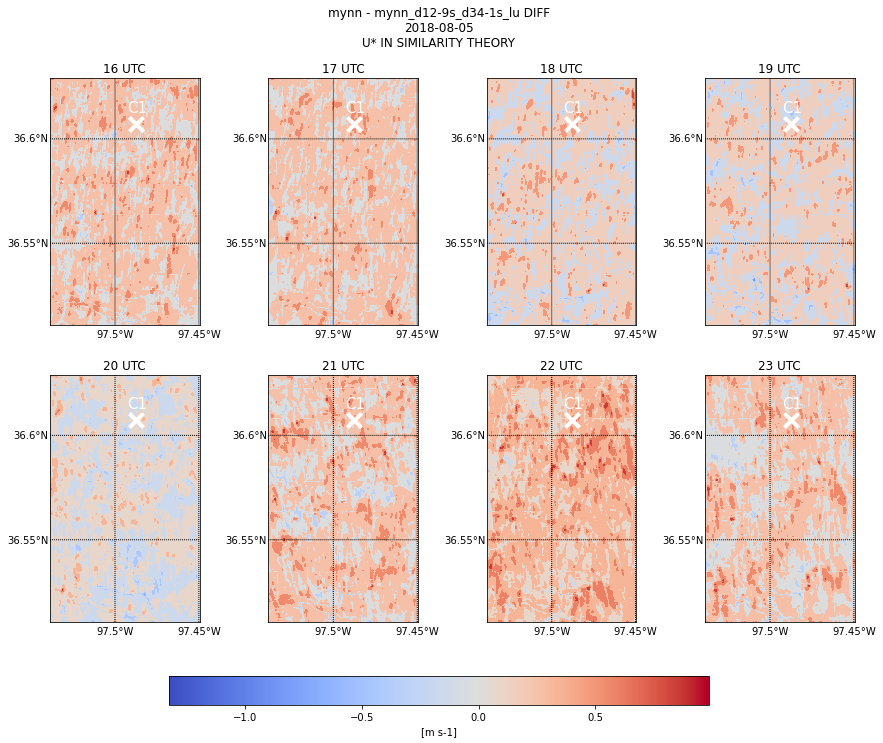

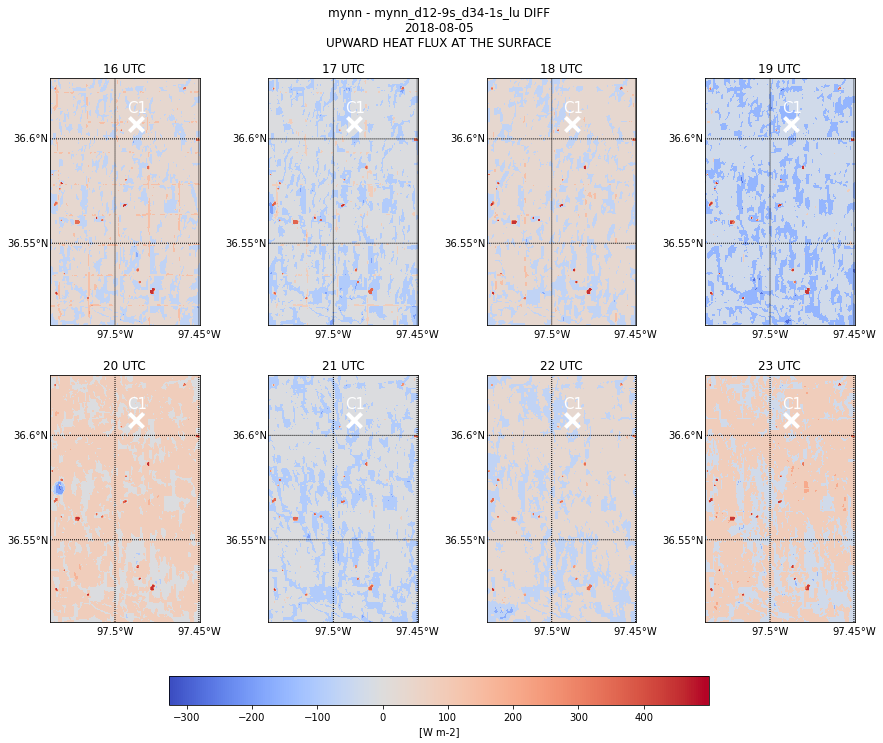

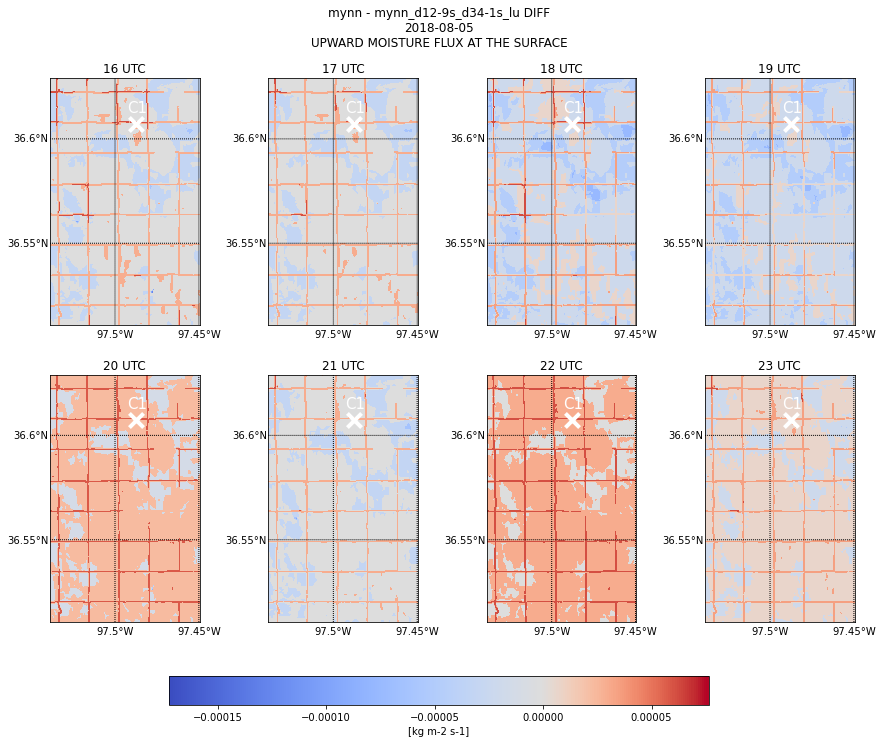

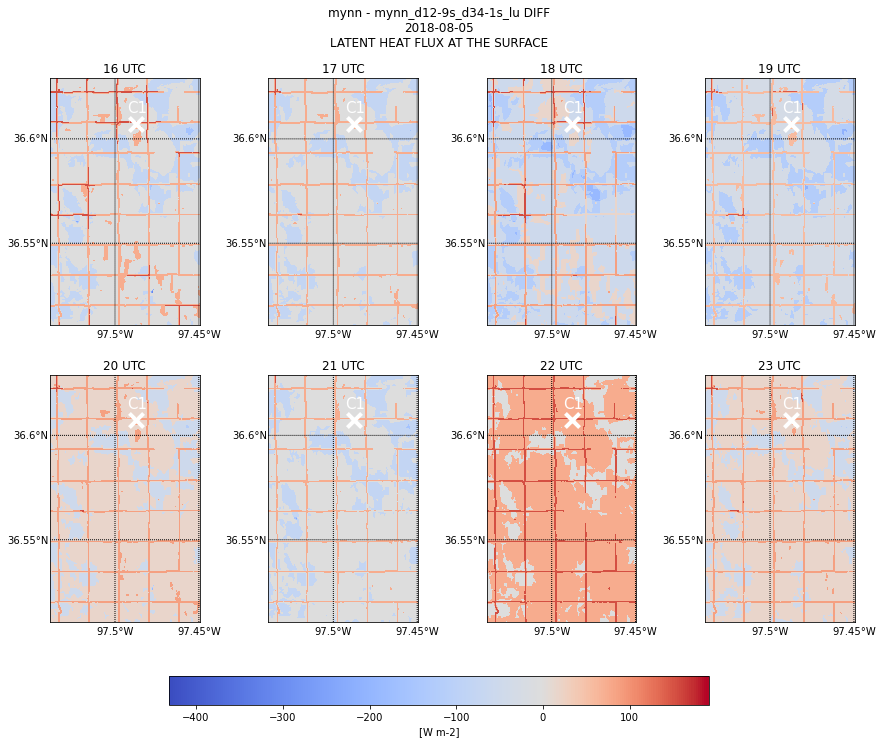

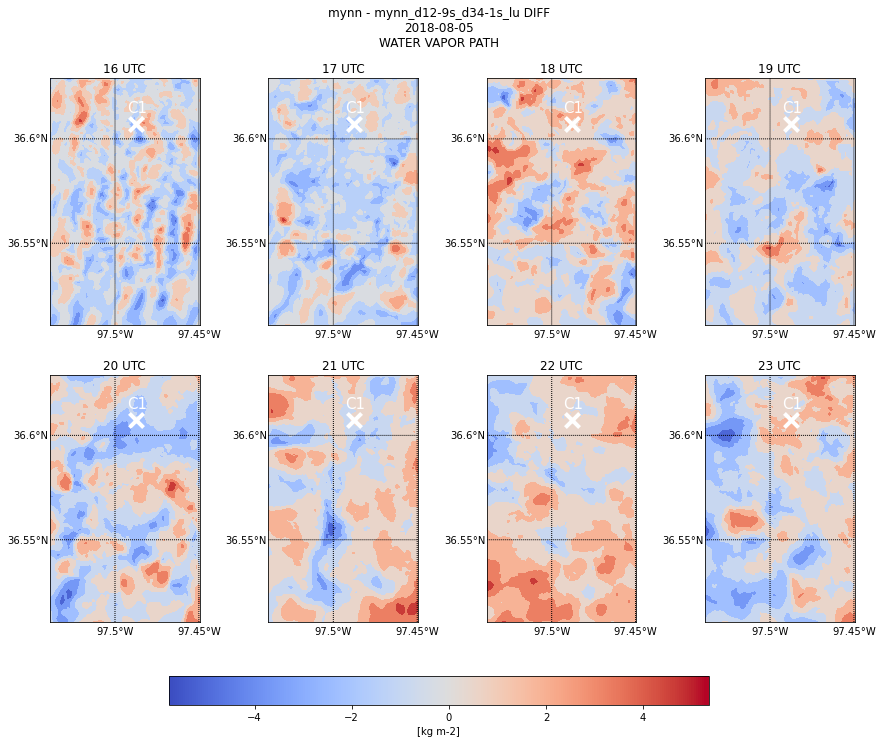

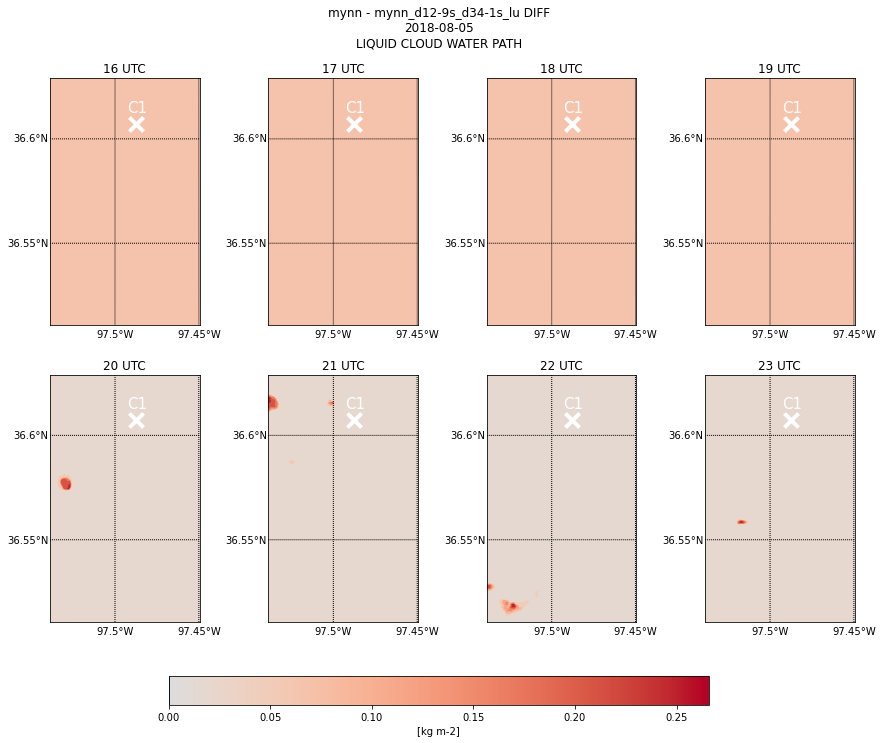

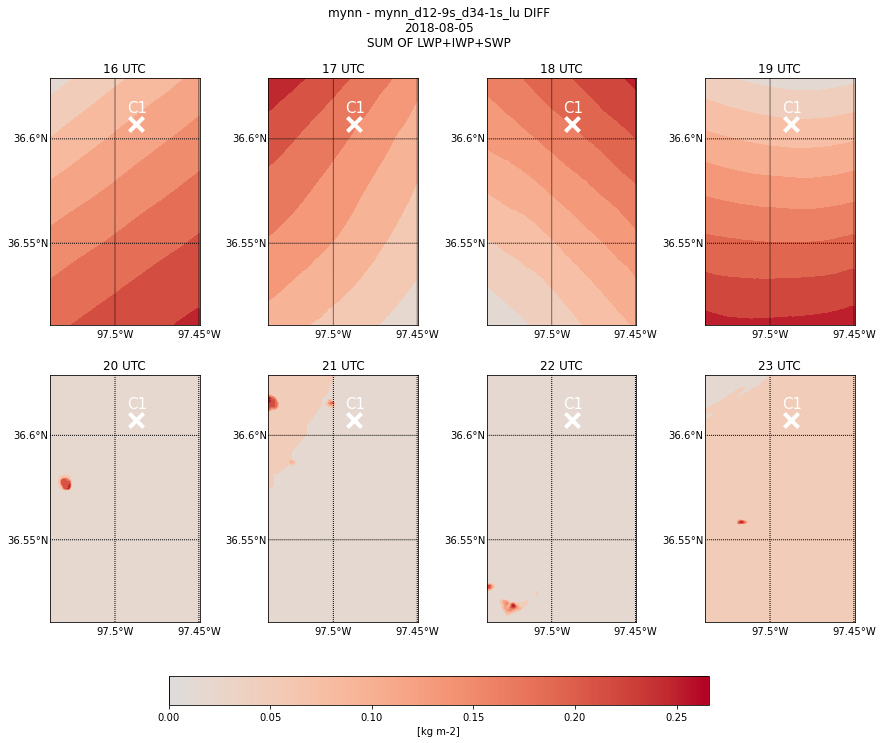

ValueError: 'QVAPOR' is not a valid variable name

In [5]:
eval_date = '2018-08-05'
run1 = 'mynn'
run2 = 'mynn_d12-9s_d34-1s_lu'
wrf_var = 'HFX'
# plot_var = 'wspd'
# var_list = ['TSK', 'Q2', 'VAR', 'SWDOWN', 'SWDOWN2', 'SWNORM', 'UST', 
#             'HFX', 'QFX', 'LH', 'WVP', 'LWP', 'WP_SUM']

var_list = ['TSK', 'Q2', 'VAR', 'SWDOWN', 'SWDOWN2', 'SWNORM', 'UST', 
            'HFX', 'QFX', 'LH', 'WVP', 'LWP', 'WP_SUM', 'QCLOUD', 'CLDFRA']

for wrf_var in var_list:
    plot_1lev_diff_contour(run1, run2, wrf_var)

In [22]:
1-(v_max/(v_max+abs(v_min)))

<xarray.DataArray 'HFX' ()>
array(0.39570484)

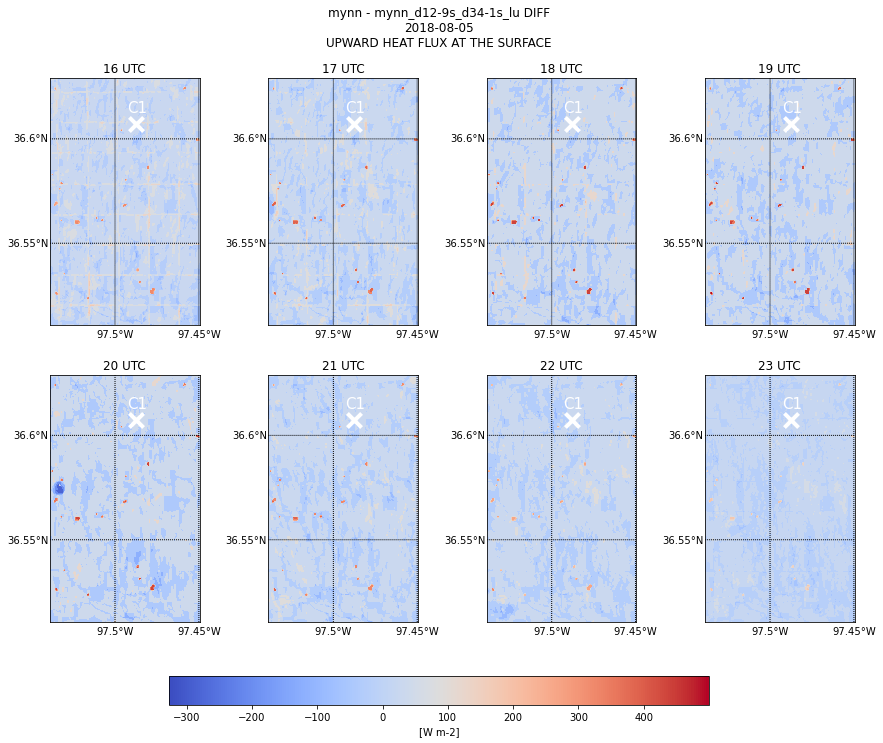

In [7]:
eval_date = '2018-08-05'
run1 = 'mynn'
run2 = 'mynn_d12-9s_d34-1s_lu'
wrf_var = 'HFX'
# plot_var = 'wspd'
# var_list = ['TSK', 'Q2', 'VAR', 'SWDOWN', 'SWDOWN2', 'SWNORM', 'UST', 
#             'HFX', 'QFX', 'LH', 'WVP', 'LWP', 'WP_SUM']

date_col = data_dir_df[eval_date]

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file1 = wrf_runs_dir+date_col[run1]+'/wrfout_d04_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single1 = Dataset(file1, 'r')

    var1 = wrf.getvar(wrf_single1, wrf_var, timeidx=wrf.ALL_TIMES)

    if ind == 0: 
        var_all1 = var1
    else: 
        var_all1 = xr.concat([var_all1, var1], dim='Time')
        
    file2 = wrf_runs_dir+date_col[run2]+'/wrfout_d04_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single2 = Dataset(file2, 'r')

    var2 = wrf.getvar(wrf_single2, wrf_var, timeidx=wrf.ALL_TIMES)

    if ind == 0: 
        var_all2 = var2
    else: 
        var_all2 = xr.concat([var_all2, var2], dim='Time')
        
var_all = var_all1 - var_all2

var_all = var_all.assign_coords(var_all1.coords)
var_all = var_all.assign_attrs(var_all1.attrs)

lats, lons = wrf.latlon_coords(var_all)

fig, (axs1, axs2) = plt.subplots(2, 4, figsize=(15, 10))

time_list = pd.date_range(start=eval_date+'-16', end=eval_date+'-23', periods=8)

var_subset = var_all.sel(Time=slice(time_list.min(), time_list.max()))
v_min = var_subset.min()
v_max = var_subset.max()

# orig_cmap = matplotlib.cm.coolwarm
# shrunk_cmap = shiftedColorMap(orig_cmap, start=v_min, midpoint=0, stop=v_max, name='shrunk')

for ind, time in enumerate(time_list):

    var_1time = var_subset.sel(Time=time)

    if ind <= 3: 
        axs = axs1
    else: 
        axs = axs2
        ind -= 4

    bm = wrf.get_basemap(var_1time, ax=axs[ind])

    bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
    bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

    x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

    p = bm.contourf(x, y, wrf.to_np(var_1time), 10, cmap='coolwarm', 
                    vmin=v_min, vmax=v_max)

    axs[ind].set_title(str(time.hour)+' UTC')

    c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
    bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=axs[ind])

    c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.613))
    axs[ind].annotate('C1', xy=(c1x, c1y), size=15, color='white')

cax = plt.axes([0.25, 0.01, 0.5, 0.04])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=v_min, vmax=v_max))
cb = plt.colorbar(sm, cax=cax, orientation='horizontal', label='['+var_all.units+']')

plt.suptitle(run1+' - '+run2+' DIFF\n'+eval_date+'\n'+var_all.description)

#     plt.savefig(plots_dir+'/'+eval_date+'_'+wrf_var+'_'+run+'.pdf')

plt.show()

In [10]:
wrf_single2

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2018-08-05_15:00:00
    SIMULATION_START_DATE: 2018-08-04_12:00:00
    WEST-EAST_GRID_DIMENSION: 201
    SOUTH-NORTH_GRID_DIMENSION: 331
    BOTTOM-TOP_GRID_DIMENSION: 109
    DX: 40.0
    DY: 40.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 2
    KM_OPT: 2
    DAMP_OPT: 3
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 28
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 5
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 0
    CU_PHYSICS: 0
    SF_LAKE_PHYSICS: 0
    USE_BATHYMETRY: 0
    SURFACE_INPUT_SOURCE: 3
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
 

In [39]:
var_all.assign_attrs(var_all1.attrs)

<xarray.DataArray 'HFX' (Time: 8, south_north: 330, west_east: 200)>
array([[[ 2.97384552e+02, -4.07781067e+01, -3.29086304e+01, ...,
         -4.41846924e+01, -4.51887207e+01, -4.23828430e+01],
        [-3.35209961e+01, -4.30946045e+01, -3.19787598e+01, ...,
         -4.50538635e+01, -4.69130859e+01, -4.30457458e+01],
        [-3.31734924e+01, -3.22833252e+01, -2.23953552e+01, ...,
         -6.10461731e+01, -4.46728516e+01, -4.49562378e+01],
        ...,
        [-1.52124634e+01, -1.21685791e+01,  4.43531647e+01, ...,
          7.51882935e+00,  1.99506836e+01,  1.48378143e+01],
        [-1.50113831e+01, -2.21463013e+00,  5.22326813e+01, ...,
          2.05383301e-02,  2.05028687e+01,  1.41149750e+01],
        [-1.27637939e+01,  1.18661499e+00,  2.74343872e+00, ...,
         -3.37069702e+00,  4.87341309e+00,  4.25094604e+00]],

       [[ 3.64262451e+02, -5.59238586e+01, -4.91529236e+01, ...,
         -6.40736694e+01, -8.09564209e+01, -8.50376587e+01],
        [-4.94024353e+01, -4.82206726e+01, -4.53061523e+01, ...,
         -5.57055054e+01, -7.77451782e+01, -8.22701111e+01],
        [-4.55850830e+01, -4.29411316e+01, -4.52751160e+01, ...,
         -8.03076782e+01, -6.84979858e+01, -7.75643921e+01],
...
         -4.96879578e+00, -4.21368408e+00, -1.69723511e+00],
        [-3.81940765e+01, -3.84814911e+01,  7.94641113e+00, ...,
         -5.40576172e+00, -1.06330872e+00, -1.61413574e+00],
        [-3.79896851e+01, -3.84332733e+01, -3.82054443e+01, ...,
         -3.23062134e+00,  1.73881531e+00, -3.43933105e-01]],

       [[ 1.55004105e+02,  1.45836639e+00,  4.27206421e+00, ...,
         -1.93233948e+01, -2.07343521e+01, -2.14627228e+01],
        [ 4.74395752e-02,  2.49401855e+00,  7.05249023e+00, ...,
         -1.98918152e+01, -2.14085388e+01, -2.12328339e+01],
        [-1.23580933e-01,  3.05205536e+00,  4.39202118e+00, ...,
         -2.50176544e+01, -2.05403290e+01, -2.12212982e+01],
        ...,
        [ 2.47612000e-01,  7.97889709e-01,  2.87546082e+01, ...,
          2.09410324e+01,  2.31044617e+01,  2.38627090e+01],
        [ 5.28594971e-01,  4.11811829e+00,  3.04412689e+01, ...,
          2.18951645e+01,  2.47023087e+01,  2.39091034e+01],
        [-1.92527771e-01,  4.25158691e+00,  3.01200104e+00, ...,
          2.20383377e+01,  2.42816010e+01,  2.29201050e+01]]],
      dtype=float32)
Coordinates:
    XTIME    (Time) float32 1.68e+03 1.74e+03 1.8e+03 ... 2.04e+03 2.1e+03
  * Time     (Time) datetime64[ns] 2018-08-05T16:00:00 ... 2018-08-05T23:00:00
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.63 36.63
    XLONG    (south_north, west_east) float32 -97.54 -97.54 ... -97.45 -97.45
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [27]:
var_all1 - var_all2

<xarray.DataArray 'HFX' (Time: 8, south_north: 330, west_east: 200)>
array([[[ 2.97384552e+02, -4.07781067e+01, -3.29086304e+01, ...,
         -4.41846924e+01, -4.51887207e+01, -4.23828430e+01],
        [-3.35209961e+01, -4.30946045e+01, -3.19787598e+01, ...,
         -4.50538635e+01, -4.69130859e+01, -4.30457458e+01],
        [-3.31734924e+01, -3.22833252e+01, -2.23953552e+01, ...,
         -6.10461731e+01, -4.46728516e+01, -4.49562378e+01],
        ...,
        [-1.52124634e+01, -1.21685791e+01,  4.43531647e+01, ...,
          7.51882935e+00,  1.99506836e+01,  1.48378143e+01],
        [-1.50113831e+01, -2.21463013e+00,  5.22326813e+01, ...,
          2.05383301e-02,  2.05028687e+01,  1.41149750e+01],
        [-1.27637939e+01,  1.18661499e+00,  2.74343872e+00, ...,
         -3.37069702e+00,  4.87341309e+00,  4.25094604e+00]],

       [[ 3.64262451e+02, -5.59238586e+01, -4.91529236e+01, ...,
         -6.40736694e+01, -8.09564209e+01, -8.50376587e+01],
        [-4.94024353e+01, -4.82206726e+01, -4.53061523e+01, ...,
         -5.57055054e+01, -7.77451782e+01, -8.22701111e+01],
        [-4.55850830e+01, -4.29411316e+01, -4.52751160e+01, ...,
         -8.03076782e+01, -6.84979858e+01, -7.75643921e+01],
...
         -4.96879578e+00, -4.21368408e+00, -1.69723511e+00],
        [-3.81940765e+01, -3.84814911e+01,  7.94641113e+00, ...,
         -5.40576172e+00, -1.06330872e+00, -1.61413574e+00],
        [-3.79896851e+01, -3.84332733e+01, -3.82054443e+01, ...,
         -3.23062134e+00,  1.73881531e+00, -3.43933105e-01]],

       [[ 1.55004105e+02,  1.45836639e+00,  4.27206421e+00, ...,
         -1.93233948e+01, -2.07343521e+01, -2.14627228e+01],
        [ 4.74395752e-02,  2.49401855e+00,  7.05249023e+00, ...,
         -1.98918152e+01, -2.14085388e+01, -2.12328339e+01],
        [-1.23580933e-01,  3.05205536e+00,  4.39202118e+00, ...,
         -2.50176544e+01, -2.05403290e+01, -2.12212982e+01],
        ...,
        [ 2.47612000e-01,  7.97889709e-01,  2.87546082e+01, ...,
          2.09410324e+01,  2.31044617e+01,  2.38627090e+01],
        [ 5.28594971e-01,  4.11811829e+00,  3.04412689e+01, ...,
          2.18951645e+01,  2.47023087e+01,  2.39091034e+01],
        [-1.92527771e-01,  4.25158691e+00,  3.01200104e+00, ...,
          2.20383377e+01,  2.42816010e+01,  2.29201050e+01]]],
      dtype=float32)
Coordinates:
    XTIME    (Time) float32 1.68e+03 1.74e+03 1.8e+03 ... 2.04e+03 2.1e+03
  * Time     (Time) datetime64[ns] 2018-08-05T16:00:00 ... 2018-08-05T23:00:00
Dimensions without coordinates: south_north, west_east

In [25]:
var_all2

<xarray.DataArray 'HFX' (Time: 8, south_north: 330, west_east: 200)>
array([[[-19.4271  , 318.5335  , 310.9019  , ..., 318.33865 ,
         320.6517  , 320.10986 ],
        [311.44202 , 320.52994 , 309.3914  , ..., 316.54675 ,
         319.6336  , 319.4315  ],
        [311.08917 , 312.4915  , 303.47928 , ..., 331.53015 ,
         316.59085 , 320.00037 ],
        ...,
        [288.3372  , 287.31354 , 231.98106 , ..., 265.7922  ,
         254.8262  , 254.36357 ],
        [287.9774  , 280.59875 , 227.57045 , ..., 270.99225 ,
         251.87326 , 255.21434 ],
        [286.41476 , 277.43314 , 277.52713 , ..., 271.35092 ,
         259.62283 , 259.96207 ]],

       [[-36.389935, 381.6998  , 372.1061  , ..., 364.77615 ,
         380.10062 , 383.1074  ],
        [378.7713  , 373.96613 , 367.61328 , ..., 356.53738 ,
         376.79282 , 380.52075 ],
        [376.08945 , 368.33707 , 367.5601  , ..., 382.0585  ,
         368.5421  , 376.52396 ],
...
        [219.58035 , 218.22514 , 171.0379  , ..., 206.18753 ,
         205.40042 , 204.54765 ],
        [219.39139 , 217.36983 , 170.59686 , ..., 207.62277 ,
         202.7885  , 204.41602 ],
        [219.46268 , 217.59016 , 216.92607 , ..., 206.66328 ,
         201.49023 , 203.96423 ]],

       [[-27.16338 , 127.764336, 125.53468 , ..., 137.3111  ,
         140.10335 , 141.99695 ],
        [127.76591 , 126.78938 , 122.791534, ..., 137.30006 ,
         140.37517 , 141.23286 ],
        [127.99883 , 125.99041 , 125.81306 , ..., 141.61777 ,
         138.85562 , 140.57088 ],
        ...,
        [103.71097 , 104.07671 ,  76.263374, ..., 111.42835 ,
         110.48137 , 109.8711  ],
        [102.88314 , 101.16838 ,  75.56973 , ..., 111.19512 ,
         109.81728 , 109.611404],
        [103.223785, 100.50016 , 102.57627 , ..., 110.820915,
         109.15535 , 109.29315 ]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.54 -97.54 ... -97.45 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.63 36.63
    XTIME    (Time) float32 1.68e+03 1.74e+03 1.8e+03 ... 2.04e+03 2.1e+03
  * Time     (Time) datetime64[ns] 2018-08-05T16:00:00 ... 2018-08-05T23:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [26]:
var_all1

<xarray.DataArray 'HFX' (Time: 8, south_north: 330, west_east: 200)>
array([[[277.95746 , 277.7554  , 277.99326 , ..., 274.15396 ,
         275.46298 , 277.72702 ],
        [277.92102 , 277.43533 , 277.41263 , ..., 271.4929  ,
         272.72052 , 276.38574 ],
        [277.91568 , 280.20816 , 281.08392 , ..., 270.48398 ,
         271.918   , 275.04413 ],
        ...,
        [273.12473 , 275.14496 , 276.33423 , ..., 273.31104 ,
         274.7769  , 269.2014  ],
        [272.966   , 278.38412 , 279.80313 , ..., 271.0128  ,
         272.37613 , 269.3293  ],
        [273.65097 , 278.61975 , 280.27057 , ..., 267.98022 ,
         264.49625 , 264.213   ]],

       [[327.87253 , 325.77594 , 322.9532  , ..., 300.70248 ,
         299.1442  , 298.06973 ],
        [329.36887 , 325.74545 , 322.30713 , ..., 300.83188 ,
         299.04764 , 298.25064 ],
        [330.50436 , 325.39594 , 322.28497 , ..., 301.75082 ,
         300.04413 , 298.95956 ],
...
        [180.83226 , 178.55258 , 177.5725  , ..., 201.21873 ,
         201.18674 , 202.85042 ],
        [181.19731 , 178.88834 , 178.54327 , ..., 202.21701 ,
         201.72519 , 202.80188 ],
        [181.47299 , 179.15689 , 178.72063 , ..., 203.43266 ,
         203.22905 , 203.6203  ]],

       [[127.84072 , 129.2227  , 129.80675 , ..., 117.9877  ,
         119.368996, 120.534225],
        [127.81335 , 129.2834  , 129.84402 , ..., 117.40825 ,
         118.96663 , 120.00003 ],
        [127.87525 , 129.04247 , 130.20508 , ..., 116.60011 ,
         118.31529 , 119.34958 ],
        ...,
        [103.95858 , 104.8746  , 105.01798 , ..., 132.36938 ,
         133.58583 , 133.73381 ],
        [103.411736, 105.2865  , 106.011   , ..., 133.09029 ,
         134.51959 , 133.52051 ],
        [103.03126 , 104.75175 , 105.58827 , ..., 132.85925 ,
         133.43695 , 132.21326 ]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.54 -97.54 ... -97.45 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.63 36.63
    XTIME    (Time) float32 1.68e+03 1.74e+03 1.8e+03 ... 2.04e+03 2.1e+03
  * Time     (Time) datetime64[ns] 2018-08-05T16:00:00 ... 2018-08-05T23:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [ ]:
def plot_1lev_contour(run, wrf_var):

    date_col = data_dir_df[eval_date]

    for ind, hr in enumerate(np.arange(16, 24, 1)): 

        file = wrf_runs_dir+date_col[run]+'/wrfout_d04_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single = Dataset(file, 'r')

        var = wrf.getvar(wrf_single, wrf_var, timeidx=wrf.ALL_TIMES)

        if ind == 0: 
            var_all = var
        else: 
            var_all = xr.concat([var_all, var], dim='Time')

    lats, lons = wrf.latlon_coords(var_all)

    fig, (axs1, axs2) = plt.subplots(2, 4, figsize=(15, 10))

    time_list = pd.date_range(start=eval_date+'-16', end=eval_date+'-23', periods=8)

    var_subset = var_all.sel(Time=slice(time_list.min(), time_list.max()))
    v_min = var_subset.min()
    v_max = var_subset.max()

    for ind, time in enumerate(time_list):

        var_1time = var_subset.sel(Time=time)

        if ind <= 3: 
            axs = axs1
        else: 
            axs = axs2
            ind -= 4

        bm = wrf.get_basemap(var_1time, ax=axs[ind])

        bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
        bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

        x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

        p = bm.contourf(x, y, wrf.to_np(var_1time), 10, cmap=get_cmap('viridis'), 
                        vmin=v_min, vmax=v_max)

        axs[ind].set_title(str(time.hour)+' UTC')

        c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
        bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=axs[ind])

        c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.613))
        axs[ind].annotate('C1', xy=(c1x, c1y), size=15, color='white')

    cax = plt.axes([0.25, 0.01, 0.5, 0.04])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=v_min, vmax=v_max))
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal', label='['+var_all.units+']')

    plt.suptitle(run+'\n'+eval_date+'\n'+var_all.description)

#     plt.savefig(plots_dir+'/'+eval_date+'_'+wrf_var+'_'+run+'.pdf')

    plt.show()

In [ ]:
eval_date = '2018-08-05'
# run = 'mynn'
# wrf_var = 'HFX'
# plot_var = 'wspd'
var_list = ['TSK', 'Q2', 'VAR', 'SWDOWN', 'SWDOWN2', 'SWNORM', 'UST', 
            'HFX', 'QFX', 'LH', 'WVP', 'LWP', 'WP_SUM']

for run in runs_list:
    for wrf_var in var_list:
        plot_1lev_contour(run, wrf_var)